# Herschel Stripe 82 VICS82 - VHS merging

VICS 82 and VHS contain VISTA J and Ks fluxes which need to be merged

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-27 15:01:12.533619


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
from collections import OrderedDict

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
vics82 = Table.read("{}/VICS82.fits".format(TMP_DIR))
vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones:  VHS, VICS82, 

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### VHS

In [5]:
master_catalogue = vhs
master_catalogue['vhs_ra'].name = 'ra'
master_catalogue['vhs_dec'].name = 'dec'


## Add VICS82

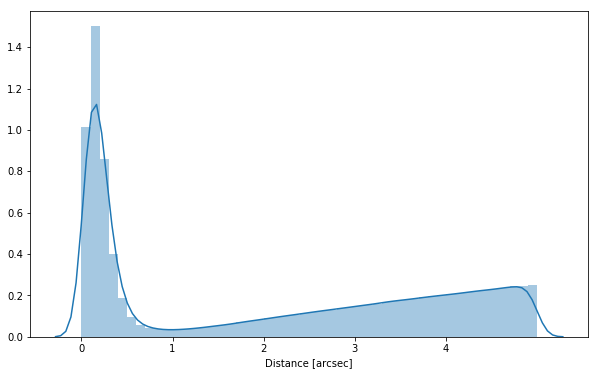

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vics82['vics82_ra'], vics82['vics82_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vics82, "vics82_ra", "vics82_dec", radius=0.8*u.arcsec)


### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [8]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [9]:
master_catalogue[:10].show_in_notebook()

idx,vhs_id,ra,dec,vhs_stellarity,m_vhs_y,merr_vhs_y,m_ap_vhs_y,merr_ap_vhs_y,m_vhs_j,merr_vhs_j,m_ap_vhs_j,merr_ap_vhs_j,m_vhs_h,merr_vhs_h,m_ap_vhs_h,merr_ap_vhs_h,m_vhs_k,merr_vhs_k,m_ap_vhs_k,merr_ap_vhs_k,f_vhs_y,ferr_vhs_y,flag_vhs_y,f_ap_vhs_y,ferr_ap_vhs_y,f_vhs_j,ferr_vhs_j,flag_vhs_j,f_ap_vhs_j,ferr_ap_vhs_j,f_vhs_h,ferr_vhs_h,flag_vhs_h,f_ap_vhs_h,ferr_ap_vhs_h,f_vhs_k,ferr_vhs_k,flag_vhs_k,f_ap_vhs_k,ferr_ap_vhs_k,vhs_flag_cleaned,vhs_flag_gaia,flag_merged,vics82_id,vics82_stellarity,vics82_flag_cleaned,f_wircam_j,f_vista_j,ferr_wircam_j,ferr_vista_j,m_wircam_j,m_vista_j,merr_wircam_j,merr_vista_j,flag_wircam_j,flag_vista_j,f_ap_wircam_j,f_ap_vista_j,ferr_ap_wircam_j,ferr_ap_vista_j,m_ap_wircam_j,m_ap_vista_j,merr_ap_wircam_j,merr_ap_vista_j,f_wircam_ks,f_vista_ks,ferr_wircam_ks,ferr_vista_ks,m_wircam_ks,m_vista_ks,merr_wircam_ks,merr_vista_ks,flag_wircam_ks,flag_vista_ks,f_ap_wircam_ks,f_ap_vista_ks,ferr_ap_wircam_ks,ferr_ap_vista_ks,m_ap_wircam_ks,m_ap_vista_ks,merr_ap_wircam_ks,merr_ap_vista_ks,vics82_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,472552085432,0.673306346297,-7.06443580379,0.999981,11.2259,0.000400582,10.7333,0.000339089,11.2295,0.000367877,11.6455,0.000379238,11.1059,0.000370037,12.1341,0.00053474,12.3747,0.00104543,12.5242,0.000705313,117397.0,43.3136,False,184788.0,57.7117,117008.0,39.6457,False,79764.9,27.8612,131105.0,44.6829,False,50856.1,25.0474,40749.2,39.2363,False,35508.6,23.067,False,3,False,-1,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,0
1,472550167438,354.799219968,-6.96604497217,0.999981,10.8381,0.000335466,10.7615,0.000342863,11.0164,0.000292732,11.3462,0.000333783,11.196,0.00044863,11.6947,0.000423534,10.9581,0.000438457,11.1149,0.000387725,167782.0,51.8406,False,180046.0,56.8565,142375.0,38.3867,False,105076.0,32.303,120667.0,49.8601,False,76229.9,29.7365,150226.0,60.6663,False,130026.0,46.4335,False,3,False,-1,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,0
2,472552084617,0.438188364583,-7.02594966115,0.999981,10.178,0.00022813,10.7626,0.000352718,10.4168,0.000227487,11.8231,0.000426508,10.2923,0.00028397,12.4207,0.000643061,11.2854,0.000447102,11.8295,0.000516409,308189.0,64.7553,False,179878.0,58.4361,247333.0,51.822,False,67725.0,26.6043,277393.0,72.5511,False,39059.1,23.134,111132.0,45.7636,False,67331.3,32.0248,False,3,False,-1,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,0
3,472533513039,350.418456023,-5.66823053354,0.999981,10.9137,0.000322981,10.942,0.000364706,11.1311,0.00032009,11.3007,0.000336604,11.5337,0.000492512,11.7255,0.000409554,11.6317,0.000615116,11.6691,0.000462824,156506.0,46.5568,False,152475.0,51.2174,128102.0,37.7661,False,109580.0,33.9723,88411.6,40.1053,False,74097.2,27.9505,80783.1,45.7671,False,78049.1,33.2705,False,3,False,-1,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,0
4,472552083412,0.508092945481,-6.96580681684,0.999981,10.484,0.000259921,10.8517,0.000366054,11.1097,0.000330767,11.5884,0.000380202,11.1516,0.000438414,11.7072,0.000447009,11.3865,0.000529828,11.6285,0.000466596,232479.0,55.6547,False,165703.0,55.8663,130656.0,39.804,False,84069.7,29.4394,125703.0,50.758,False,75355.3,31.0245,101252.0,49.41,False,81022.1,34.8193,False,3,False,-1,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,nan,nan,nan,nan,nan,nan,nan,0
5,472552083136,0.360617270106,-6.95299694223,0.999981,10.5721,0.000280615,10.9244,0.00037351,10.9582,0.000310081,11.8008,0.000410

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [10]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="vista_flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [11]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="vista_flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [12]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="vista_stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [13]:
master_catalogue.add_column(Column(data=np.arange(len(master_catalogue)), 
                              name="vista_intid"))


In [14]:

id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['vhs_id', 'vics82_id', 'vista_intid']


## VI - Choosing between multiple values for the same filter



In [15]:
vista_origin = Table()
vista_origin.add_column(master_catalogue['vista_intid'])

In [16]:
vista_stats = Table()
vista_stats.add_column(Column(data=['j','ks'], name="Band"))
for col in ["VHS", "VICS82"]:
    vista_stats.add_column(Column(data=np.full(2, 0), name="{}".format(col)))
    vista_stats.add_column(Column(data=np.full(2, 0), name="use {}".format(col)))
    vista_stats.add_column(Column(data=np.full(2, 0), name="{} ap".format(col)))
    vista_stats.add_column(Column(data=np.full(2, 0), name="use {} ap".format(col)))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(2, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [17]:
vista_bands = ['j','ks'] # Lowercase naming convention (k is Ks)
for band in vista_bands:


    # VISTA total flux 
    has_vhs = ~np.isnan(master_catalogue['f_vhs_' + band.strip('s')])
    has_vics82 = ~np.isnan(master_catalogue['f_vista_' + band])

    use_vhs = has_vhs 
    use_vics82 = has_vics82 & ~has_vhs


    master_catalogue['f_vista_' + band][use_vhs] = master_catalogue['f_vhs_' + band.strip('s')][use_vhs]
    master_catalogue['ferr_vista_' + band][use_vhs] = master_catalogue['ferr_vhs_' + band.strip('s')][use_vhs]
    master_catalogue['m_vista_' + band][use_vhs] = master_catalogue['m_vhs_' + band.strip('s')][use_vhs]
    master_catalogue['merr_vista_' + band][use_vhs] = master_catalogue['merr_vhs_' + band.strip('s')][use_vhs]
    master_catalogue['flag_vista_' + band][use_vhs] = master_catalogue['flag_vhs_' + band.strip('s')][use_vhs]

    master_catalogue.remove_columns(['f_vhs_' + band.strip('s'),
                               'ferr_vhs_' + band.strip('s'),
                               'm_vhs_' + band.strip('s'), 
                               'merr_vhs_' + band.strip('s'),
                               'flag_vhs_' + band.strip('s')])

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_vhs] = "VHS"
    origin[use_vics82] = "VICS82"

    
    vista_origin.add_column(Column(data=origin, name= 'f_vista_' + band ))
    
    # VISTA aperture flux 
    has_ap_vhs = ~np.isnan(master_catalogue['f_ap_vhs_' + band.strip('s')])
    has_ap_vics82 = ~np.isnan(master_catalogue['f_ap_vista_' + band])

    use_ap_vhs = has_ap_vhs 
    use_ap_vics82 = has_ap_vics82 & ~has_ap_vhs


    master_catalogue['f_ap_vista_' + band][use_ap_vhs] = master_catalogue['f_ap_vhs_' + band.strip('s')][use_ap_vhs]
    master_catalogue['ferr_ap_vista_' + band][use_ap_vhs] = master_catalogue['ferr_ap_vhs_' + band.strip('s')][use_ap_vhs]
    master_catalogue['m_ap_vista_' + band][use_ap_vhs] = master_catalogue['m_ap_vhs_' + band.strip('s')][use_ap_vhs]
    master_catalogue['merr_ap_vista_' + band][use_ap_vhs] = master_catalogue['merr_ap_vhs_' + band.strip('s')][use_ap_vhs]
  

    master_catalogue.remove_columns(['f_ap_vhs_' + band.strip('s'),
                               'ferr_ap_vhs_' + band.strip('s'),
                               'm_ap_vhs_' + band.strip('s'), 
                               'merr_ap_vhs_' + band.strip('s')])

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_vhs] = "VHS"
    origin_ap[use_ap_vics82] = "VICS82"

    
    vista_origin.add_column(Column(data=origin_ap, name= 'f_ap_vista_' + band ))   

   
    vista_stats['VHS'][vista_stats['Band'] == band] = np.sum(has_vhs)
    vista_stats['VICS82'][vista_stats['Band'] == band] = np.sum(has_vics82)

    vista_stats['use VHS'][vista_stats['Band'] == band] = np.sum(use_vhs)
    vista_stats['use VICS82'][vista_stats['Band'] == band] = np.sum(use_vics82)

    vista_stats['VHS ap'][vista_stats['Band'] == band] = np.sum(has_ap_vhs)
    vista_stats['VICS82 ap'][vista_stats['Band'] == band] = np.sum(has_ap_vics82)

    vista_stats['use VHS ap'][vista_stats['Band'] == band] = np.sum(use_ap_vhs)
    vista_stats['use VICS82 ap'][vista_stats['Band'] == band] = np.sum(use_ap_vics82)


In [18]:
vista_stats.show_in_notebook()

idx,Band,VHS,use VHS,VHS ap,use VHS ap,VICS82,use VICS82,VICS82 ap,use VICS82 ap
0,j,3245957.0,3245957.0,3245540.0,3245540.0,1835512.0,1342797.0,1809064.0,1316380.0
1,ks,2408910.0,2408910.0,2406285.0,2406285.0,5422089.0,5004714.0,5075374.0,4658049.0


In [19]:
vista_origin.write("{}/herschel-stripe-82_vista_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## Rename old vhs cols

In [20]:

renaming = OrderedDict({
    '_vhs_y': '_vista_y',
    '_vhs_h': '_vista_h',

})


for col in master_catalogue.colnames:
    for rename_col in list(renaming):
        if rename_col in col:
            master_catalogue.rename_column(col, col.replace(rename_col, renaming[rename_col]))

## IX - Saving the catalogue

In [21]:
master_catalogue["ra"].name = "vista_ra"
master_catalogue["dec"].name = "vista_dec"
master_catalogue["flag_merged"].name = "vista_flag_merged"

In [22]:
columns = ["vhs_id", "vics82_id", "vista_intid",
           'vista_ra', 'vista_dec', 'vista_flag_merged',  
           'vista_flag_cleaned',  'vista_flag_gaia', 'vista_stellarity']

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    


In [23]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: set()


In [24]:
master_catalogue[:10].show_in_notebook()

idx,vhs_id,vista_ra,vista_dec,m_vista_y,merr_vista_y,m_ap_vista_y,merr_ap_vista_y,m_vista_h,merr_vista_h,m_ap_vista_h,merr_ap_vista_h,f_vista_y,ferr_vista_y,flag_vista_y,f_ap_vista_y,ferr_ap_vista_y,f_vista_h,ferr_vista_h,flag_vista_h,f_ap_vista_h,ferr_ap_vista_h,vista_flag_merged,vics82_id,f_wircam_j,f_vista_j,ferr_wircam_j,ferr_vista_j,m_wircam_j,m_vista_j,merr_wircam_j,merr_vista_j,flag_wircam_j,flag_vista_j,f_ap_wircam_j,f_ap_vista_j,ferr_ap_wircam_j,ferr_ap_vista_j,m_ap_wircam_j,m_ap_vista_j,merr_ap_wircam_j,merr_ap_vista_j,f_wircam_ks,f_vista_ks,ferr_wircam_ks,ferr_vista_ks,m_wircam_ks,m_vista_ks,merr_wircam_ks,merr_vista_ks,flag_wircam_ks,flag_vista_ks,f_ap_wircam_ks,f_ap_vista_ks,ferr_ap_wircam_ks,ferr_ap_vista_ks,m_ap_wircam_ks,m_ap_vista_ks,merr_ap_wircam_ks,merr_ap_vista_ks,vista_flag_cleaned,vista_flag_gaia,vista_stellarity,vista_intid
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,472552085432,0.673306346297,-7.06443580379,11.2259,0.000400582,10.7333,0.000339089,11.1059,0.000370037,12.1341,0.00053474,117397.0,43.3136,False,184788.0,57.7117,131105.0,44.6829,False,50856.1,25.0474,False,-1,nan,117008.304688,nan,39.645652771,nan,11.2294578552,nan,0.00036787748104,False,False,nan,79764.9,nan,27.8611602783,nan,11.6455,nan,0.000379237753805,nan,40749.1757812,nan,39.2363166809,nan,12.3747024536,nan,0.0010454270523,False,False,nan,35508.6,nan,23.0669689178,nan,12.5242,nan,0.000705312821083,False,3,0.999980926514,0
1,472550167438,354.799219968,-6.96604497217,10.8381,0.000335466,10.7615,0.000342863,11.196,0.00044863,11.6947,0.000423534,167782.0,51.8406,False,180046.0,56.8565,120667.0,49.8601,False,76229.9,29.7365,False,-1,nan,142375.328125,nan,38.3867149353,nan,11.016412735,nan,0.000292732205708,False,False,nan,105076.0,nan,32.3030281067,nan,11.3462,nan,0.00033378295484,nan,150226.046875,nan,60.6663398743,nan,10.9581365585,nan,0.000438456889242,False,False,nan,130026.0,nan,46.4335289001,nan,11.1149,nan,0.000387725478504,False,3,0.999980926514,1
2,472552084617,0.438188364583,-7.02594966115,10.178,0.00022813,10.7626,0.000352718,10.2923,0.00028397,12.4207,0.000643061,308189.0,64.7553,False,179878.0,58.4361,277393.0,72.5511,False,39059.1,23.134,False,-1,nan,247333.125,nan,51.8220443726,nan,10.4167938232,nan,0.000227486991207,False,False,nan,67725.0,nan,26.6043300629,nan,11.8231,nan,0.000426508282544,nan,111131.65625,nan,45.7635650635,nan,11.285405159,nan,0.000447101745522,False,False,nan,67331.3,nan,32.024772644,nan,11.8295,nan,0.000516408588737,False,3,0.999980926514,2
3,472533513039,350.418456023,-5.66823053354,10.9137,0.000322981,10.942,0.000364706,11.5337,0.000492512,11.7255,0.000409554,156506.0,46.5568,False,152475.0,51.2174,88411.6,40.1053,False,74097.2,27.9505,False,-1,nan,128101.617188,nan,37.7660675049,nan,11.1311130524,nan,0.000320089544402,False,False,nan,109580.0,nan,33.9722595215,nan,11.3007,nan,0.000336603581673,nan,80783.078125,nan,45.7670707703,nan,11.6316986084,nan,0.000615116034169,False,False,nan,78049.1,nan,33.2705459595,nan,11.6691,nan,0.000462824478745,False,3,0.999980926514,3
4,472552083412,0.508092945481,-6.96580681684,10.484,0.000259921,10.8517,0.000366054,11.1516,0.000438414,11.7072,0.000447009,232479.0,55.6547,False,165703.0,55.8663,125703.0,50.758,False,75355.3,31.0245,False,-1,nan,130655.976562,nan,39.8040237427,nan,11.1096763611,nan,0.000330766895786,False,False,nan,84069.7,nan,29.4394283295,nan,11.5884,nan,0.000380201876396,nan,101252.0625,nan,49.4099655151,nan,11.3864898682,nan,0.000529828073923,False,False,nan,81022.1,nan,34.8193016052,nan,11.6285,nan,0.000466595723992,False,3,0.999980926514,4
5,472552083136,0.360617270106,-6.95299694223,10.5721,0.000280615,10.9244,0.00037351,11.1491,0.000447647,12.1906,0.000554907,214362.0,55.4033,False,154972.0,53.3126,126000.0,51.9495,False,48280.6,24.6756,False,-1,nan,150219.171875,nan,42.9018821716,nan,10.9581861496,nan,0.000310081115458,False,False,nan,69130.9,nan,26.1360969543,nan,11.8008,nan,0.000410480890423,nan,89809.40625,nan,4

In [25]:
master_catalogue[columns].write("{}/vista_merged_catalogue_herschel-stripe-82.fits".format(TMP_DIR), overwrite=True)